In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor
import scipy.misc
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import time
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import cv2

seed = 0
np.random.seed(seed)
torch.manual_seed(seed);

In [2]:
device = torch.device('cpu')

In [3]:
!pwd

/scratch/cz2064/myjupyter/Computer Vision/Project/Jupyter Notebook


In [4]:
image_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Data/classification/ISIC_2019_Training_Input/'

In [5]:
train = pd.read_csv('/scratch/cz2064/myjupyter/Computer Vision/Project/Jupyter Notebook/train.csv')
train

,image,age_approx,anatom_site_general,lesion_id,sex,MEL,NV,BCC,AK,BKL,...,sex_index,age_index,anterior torso,head/neck,lateral torso,lower extremity,oral/genital,palms/soles,posterior torso,upper extremity
0,ISIC_0033863,65.0,posterior torso,HAM_0007086,female,1.0,0.0,0.0,0.0,0.0,...,0,0.65,0,0,0,0,0,0,1,0
1,ISIC_0032707,55.0,posterior torso,HAM_0007124,male,0.0,1.0,0.0,0.0,0.0,...,1,0.55,0,0,0,0,0,0,1,0
2,ISIC_0026033,60.0,lower extremity,HAM_0003319,female,0.0,1.0,0.0,0.0,0.0,...,0,0.60,0,0,0,1,0,0,0,0
3,ISIC_0033913,75.0,posterior torso,HAM_0001855,male,0.0,0.0,0.0,0.0,1.0,...,1,0.75,0,0,0,0,0,0,1,0
4,ISIC_0033740,25.0,head/neck,HAM_0005997,female,0.0,1.0,0.0,0.0,0.0,...,0,0.25,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15194,ISIC_0011140,60.0,upper extremity,NaN,female,1.0,0.0,0.0,0.0,0.0,...,0,0.60,0,0,0,0,0,0,0,1
15195,ISIC_0026940,75.0,lower extremity,HAM_0005973,male,0.0,0.0,1.0,0.0,0.0,...,1,0.75,0,0,0,1,0,0,0,0
15196,ISIC_0066907,45.0,lower extremity,BCN_0000761,male,1.0,0.0,0.0,0.0,0.0,...,1,0.45,0,0,0,1,0,0,0,0
15197,ISIC_0069691,35.0,upper extremity,BCN_0001737,male,0.0,1.0,0.0,0.0,0.0,...,1,0.35,0,0,0,0,0,0,0,1


In [6]:
train.loc[15196][['MEL','NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC','UNK']].values.astype('float')


array([1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
train.loc[15196][['sex_index','age_index','anterior torso', 'head/neck', 'lateral torso', 'lower extremity',\
                  'oral/genital', 'palms/soles', 'posterior torso', 'upper extremity']].values.astype('float')

array([1.  , 0.45, 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ])

In [8]:
train.columns

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex', 'MEL',
       'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK', 'sex_index',
       'age_index', 'anterior torso', 'head/neck', 'lateral torso',
       'lower extremity', 'oral/genital', 'palms/soles', 'posterior torso',
       'upper extremity'],
      dtype='object')

## Load sample

In [9]:
train.loc[0,'image']

'ISIC_0033863'

<class 'numpy.ndarray'>


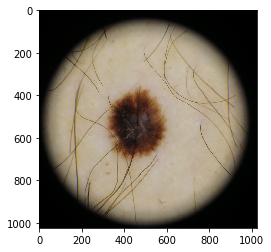

In [10]:
sample_path = image_path+train.loc[15196,'image']+'.jpg'
#sample = Image.open(sample_path)
sample = cv2.imread(sample_path)
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
print(type(sample))
plt.imshow(sample)

In [11]:
ToTensor()(sample).size()

torch.Size([3, 1024, 1024])

## Crop black edge

In [12]:
def change_size(image):
    #image=cv2.imread(read_file,1) 
    img = cv2.medianBlur(image,5) 
    b=cv2.threshold(img,15,255,cv2.THRESH_BINARY)    
    binary_image=b[1] 
    binary_image=cv2.cvtColor(binary_image,cv2.COLOR_BGR2GRAY)
    print(binary_image.shape) 
 
    x=binary_image.shape[0]
    y=binary_image.shape[1]
    edges_x=[]
    edges_y=[]
    for i in range(x):
        for j in range(y):
            if binary_image[i][j]==255:
                edges_x.append(i)
                edges_y.append(j)
 
    left=min(edges_x)        
    right=max(edges_x)  
    width=right-left  
    bottom=min(edges_y)
    top=max(edges_y) 
    height=top-bottom 
 
    pre1_picture=image[left:left+width,bottom:bottom+height] 
    print(pre1_picture.shape[:2])
    return pre1_picture     
        

(1024, 1024)
(978, 974)


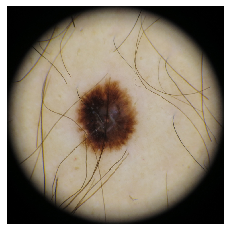

In [13]:
sample_crop = change_size(sample)
plt.imshow(sample_crop);
plt.axis('off');

## Shades of Gray color constancy

In [14]:
def shade_of_gray_cc(img, power=6, gamma=None):
    img_dtype = img.dtype

    if gamma is not None:
        img = img.astype('uint8')
        look_up_table = np.ones((256,1), dtype='uint8') * 0
        for i in range(256):
            look_up_table[i][0] = 255 * pow(i/255, 1/gamma)
        img = cv2.LUT(img, look_up_table)

    img = img.astype('float32')
    img_power = np.power(img, power)
    rgb_vec = np.power(np.mean(img_power, (0,1)), 1/power)
    rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
    rgb_vec = rgb_vec/rgb_norm
    rgb_vec = 1/(rgb_vec*np.sqrt(3))
    img = np.multiply(img, rgb_vec)

    # Andrew Anikin suggestion
    img = np.clip(img, a_min=0, a_max=255)
    
    return img.astype(img_dtype)

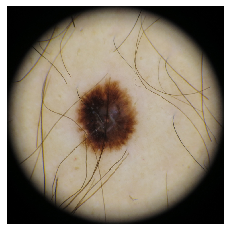

In [15]:
plt.imshow(sample_crop);
plt.axis('off');

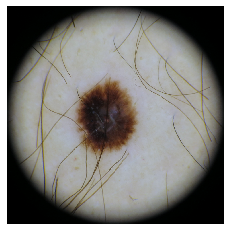

In [16]:
sample_crop = shade_of_gray_cc(sample_crop)
plt.imshow(shade_of_gray_cc(sample_crop));
plt.axis('off');

## Resize to (512xN), 512 for shorter edge

In [17]:
sample_crop.shape

(978, 974, 3)

In [18]:
target_size = 512
resize_ratio = 512/min(sample_crop.shape[0],sample_crop.shape[1])
resize_ratio

0.5256673511293635

In [19]:
cv2.resize(sample_crop,dsize=None,fx=resize_ratio,fy=resize_ratio,interpolation=cv2.INTER_AREA).shape

(514, 512, 3)

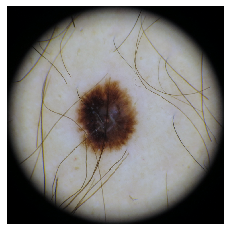

In [20]:
plt.imshow(sample_crop);
plt.axis('off');

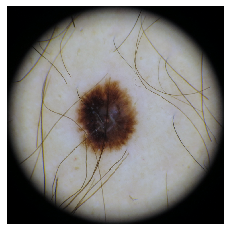

In [21]:
sample_resize = cv2.resize(sample_crop,dsize=None,fx=resize_ratio,fy=resize_ratio,interpolation=cv2.INTER_AREA)
plt.imshow(sample_crop);
plt.axis('off');

## Data Augmentation

In [22]:
train_test_normalize = transforms.Normalize([0.4373, 0.4434, 0.4725],[0.1201, 0.1231, 0.1052])

In [23]:
train_transform = transforms.Compose([])
train_transform.transforms.append(transforms.RandomHorizontalFlip())
train_transform.transforms.append(transforms.RandomVerticalFlip())
transforms.RandomRotation(180, expand=True)
#train_transform.transforms.append(transforms.RandomCrop(380, padding=0))
train_transform.transforms.append(transforms.RandomResizedCrop(380, scale=(0.08, 1.0), ratio=(1.0,1.0)))
train_transform.transforms.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0, hue=0))
train_transform.transforms.append(transforms.ToTensor())
train_transform.transforms.append(train_test_normalize)
train_transform.transforms.append(transforms.RandomErasing())

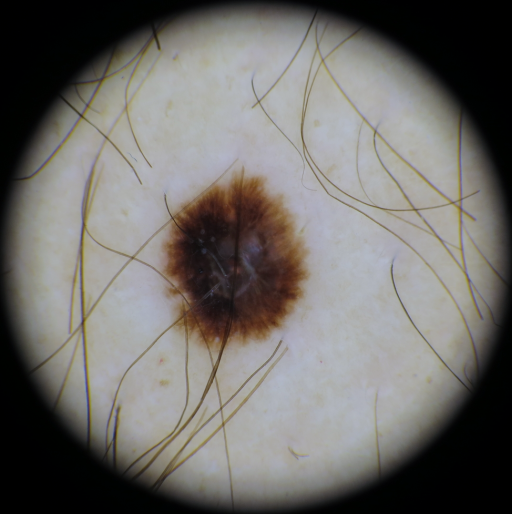

In [24]:
PIL_image = Image.fromarray(sample_resize, 'RGB')
PIL_image

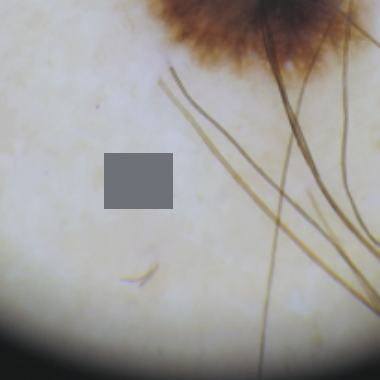

In [25]:
inv_normalize = transforms.Normalize(mean=[-0.4373/0.1201, -0.4434/0.1231, -0.4725/0.1052],\
                                     std=[1/0.1201, 1/0.1231, 1/0.1052])
image = inv_normalize(train_transform(PIL_image))
transforms.ToPILImage()(image)

train_transform = transforms.Compose([])
train_transform.transforms.append(transforms.RandomCrop(1000, padding=500))
train_transform.transforms.append(transforms.ToTensor())
train_transform.transforms.append(train_test_normalize)

PIL_image = Image.fromarray(sample_resize, 'RGB')
PIL_image

inv_normalize = transforms.Normalize(mean=[-0.4373/0.1201, -0.4434/0.1231, -0.4725/0.1052],\
                                     std=[1/0.1201, 1/0.1231, 1/0.1052])
image = inv_normalize(train_transform(PIL_image))
transforms.ToPILImage()(image)

## Data Augmentation for Segmentation 

In [26]:
train_df = pd.read_csv('seg_train.csv')
train_df.head()

,image,mask
0,ISIC_0015152.jpg,ISIC_0015152_segmentation.png
1,ISIC_0014891.jpg,ISIC_0014891_segmentation.png
2,ISIC_0000127.jpg,ISIC_0000127_segmentation.png
3,ISIC_0000530.jpg,ISIC_0000530_segmentation.png
4,ISIC_0000137.jpg,ISIC_0000137_segmentation.png


In [27]:
sample_name  = 'ISIC_0000127.jpg'
mask_name = 'ISIC_0000127_segmentation.png'

sample_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Data/segmentation/images_preprocessed/'+sample_name
mask_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Data/segmentation/mask_preprocessed/'+mask_name


In [28]:
image = Image.open(sample_path)
image;

In [29]:
type(image)

PIL.JpegImagePlugin.JpegImageFile

In [30]:
pix = np.asarray(image)

In [31]:
pix.shape

(1024, 1366, 3)

In [32]:
Image.fromarray(pix);

In [33]:
mask = Image.open(mask_path)
mask;

In [34]:
type(mask)

PIL.PngImagePlugin.PngImageFile

In [35]:
mask_array = np.asarray(mask)
mask_array.shape

(1024, 1366)

In [36]:
Image.fromarray(mask_array);

In [75]:
class DataAugmentation:
    def __init__(self,input_size=572):
        self.input_size = input_size
        pass
    
    def randomFlip(self,image, label):
        if random.randint(0, 1) == 1:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            label = label.transpose(Image.FLIP_LEFT_RIGHT)
        if random.randint(0, 1) == 1:
            image = image.transpose(Image.FLIP_TOP_BOTTOM)
            label = label.transpose(Image.FLIP_TOP_BOTTOM)
        return image,label
    
    def randomRotation(self,image, label, mode=Image.BICUBIC):
        if random.randint(0, 1) == 1:
            random_angle = np.random.randint(1, 360)
            image = image.rotate(random_angle, mode)
            label = label.rotate(random_angle, Image.NEAREST)
        return image,label
    
    
    def randomResizedCrop(self,image, label, resized_ratio=(0.2,1.0)):
        crop_size = self.input_size
        image_width = image.size[0]
        image_height = image.size[1]
        if random.randint(0, 1) == 1:
            size_resize = random.randint(int(crop_size/resized_ratio[1]+1),int(crop_size/resized_ratio[0]))
        else:
            size_resize = crop_size+1
        image = transforms.Resize(size_resize, interpolation=Image.BICUBIC)(image)
        lable = transforms.Resize(size_resize, interpolation=Image.NEAREST)(label)
        
        
        image_width = image.size[0]
        image_height = image.size[1]
        crop_left = random.randint(0,int(image_width-crop_size-1))
        crop_up = random.randint(0,int(image_height-crop_size-1))
        
        crop_box = (crop_left,crop_up,crop_left+crop_size,crop_up+crop_size)
        image = image.crop(crop_box)
        lable = lable.crop(crop_box)
        
        return image,lable
    
    def test_Resized(self,image, label):
        crop_size = self.input_size
        width = image.size[0]
        height = image.size[1]
        desired_size = max(width,height)
        new_im = Image.new("RGB", (desired_size, desired_size))
        new_im.paste(image)
        new_mask = Image.new("1", (desired_size, desired_size))
        new_mask.paste(label)
        image = transforms.Resize(crop_size, interpolation=Image.BICUBIC)(new_im)
        lable = transforms.Resize(crop_size, interpolation=Image.NEAREST)(new_mask)
        return image,lable
        
    
    def randomGaussian(self,image, label, mean=0.2, sigma=0.3):
        def gaussianNoisy(im, mean=0.2, sigma=0.3):
            for _i in range(len(im)):
                im[_i] += random.gauss(mean, sigma)
            return im

        img = np.asarray(image).copy()
        img.flags.writeable = True
        width, height = img.shape[:2]
        img_r = gaussianNoisy(img[:, :, 0].flatten(), mean, sigma)
        img_g = gaussianNoisy(img[:, :, 1].flatten(), mean, sigma)
        img_b = gaussianNoisy(img[:, :, 2].flatten(), mean, sigma)
        img[:, :, 0] = img_r.reshape([width, height])
        img[:, :, 1] = img_g.reshape([width, height])
        img[:, :, 2] = img_b.reshape([width, height])
        return Image.fromarray(np.uint8(img)), label
        
        
    def randomColor(self,image, label):
        image = transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0, hue=0)(image)
        return image,label
    
    def Normalization(self,image, label):
        image = transforms.ToTensor()(image)
        image = transforms.Normalize([0.4373, 0.4434, 0.4725],[0.1201, 0.1231, 0.1052])(image)
        label = transforms.ToTensor()(label)
        return image,label
    
    def randomCover(self,image, label,cover=128):
        if random.randint(0, 1) == 1:
            image_width = image.size(1)
            image_height = image.size(2)

            cover_left = random.randint(0,int(image_width-cover-1))
            cover_up = random.randint(0,int(image_height-cover-1))

            image[:,cover_left:(cover_left+cover),cover_up:(cover_up+cover)]=0
            label[:,cover_left:(cover_left+cover),cover_up:(cover_up+cover)]=0
        return image,label
    
    def TrainAugmentation(self,image,label):
        new_image,new_label = self.randomFlip(image,label)
        new_image,new_label = self.randomRotation(new_image,new_label)
        new_image,new_label = self.randomResizedCrop(new_image,new_label)
        new_image,new_label = self.randomGaussian(new_image,new_label)
        new_image,new_label = self.randomColor(new_image,new_label)
        new_image,new_label = self.Normalization(new_image,new_label)
        new_image,new_label = self.randomCover(new_image,new_label)
        return new_image,new_label
    
    def TestProcess(self,image,label):
        new_image,new_label = self.test_Resized(image, label)
        new_image,new_label = self.Normalization(new_image,new_label)
        return new_image,new_label

In [90]:
new_image,new_label = DataAugmentation().TestProcess(image,mask)

In [92]:
new_image,new_label = DataAugmentation().TrainAugmentation(image,mask)

new_image,new_label = DataAugmentation.randomFlip(image,mask)
new_image,new_label = DataAugmentation.randomRotation(new_image,new_label)
new_image,new_label = DataAugmentation.randomResizedCrop(new_image,new_label)
new_image,new_label = DataAugmentation.randomGaussian(new_image,new_label)
new_image,new_label = DataAugmentation.randomColor(new_image,new_label)
new_image,new_label = DataAugmentation.Normalization(new_image,new_label)
new_image,new_label = DataAugmentation.randomCover(new_image,new_label)

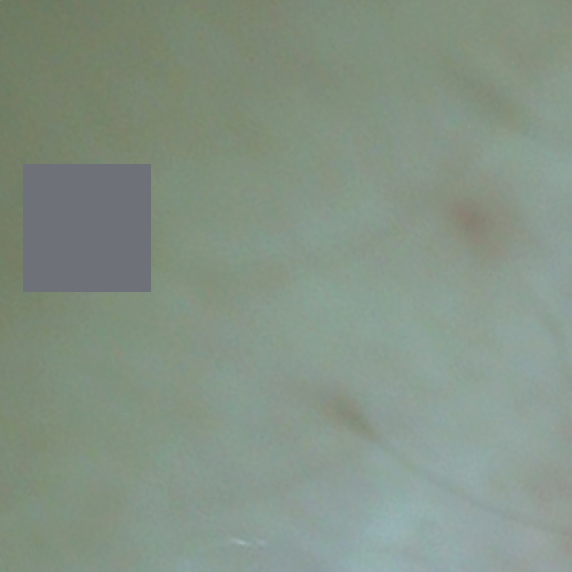

In [95]:
inv_normalize = transforms.Normalize(mean=[-0.4373/0.1201, -0.4434/0.1231, -0.4725/0.1052],\
                                     std=[1/0.1201, 1/0.1231, 1/0.1052])
inv_image = inv_normalize(new_image)
transforms.ToPILImage()(inv_image)

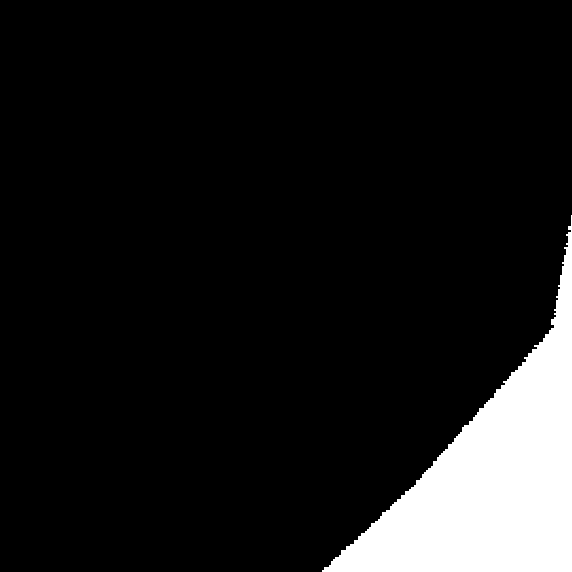

In [96]:
transforms.ToPILImage()(new_label)

In [42]:
class image_dataset(Dataset):
    def __init__(self, df_path, train = False):
        self.df = pd.read_csv(df_path)
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        image_name = self.df.iloc[idx]['image']
        image_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Data/segmentation/images_preprocessed/'\
        + image_name
        mask_name = self.df.iloc[idx]['mask']
        mask_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Data/segmentation/mask_preprocessed/'\
        + mask_name
        
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        
        if self.train:
            new_image,new_label = DataAugmentation().TrainAugmentation(image,mask)
        else:
            new_image,new_label = DataAugmentation().TestProcess(image,mask)
        
        sample={'x':new_image,'y':new_label}
        return sample

In [43]:
train_df_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Jupyter Notebook/seg_train.csv'
val_df_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Jupyter Notebook/seg_val.csv'
test_df_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Jupyter Notebook/seg_test.csv'
BATCH_SIZE = 2
train_loader = DataLoader(image_dataset(train_df_path,train = True), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(image_dataset(val_df_path), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(image_dataset(test_df_path), batch_size=BATCH_SIZE, shuffle=True)

In [44]:
next(iter(train_loader))

{'x': tensor([[[[-3.1513, -3.1840, -3.1840,  ..., -3.1840, -3.2166, -3.2493],
           [-0.7677, -0.8004, -0.8004,  ..., -0.7351, -0.7024, -0.7351],
           [-0.4085, -0.4085, -0.4412,  ..., -0.3432, -0.3106, -0.3759],
           ...,
           [-0.6371, -0.6698, -0.6371,  ..., -0.4085, -0.4738, -0.4738],
           [-0.5391, -0.5391, -0.5391,  ..., -0.2779, -0.3106, -0.3759],
           [-2.3350, -2.3677, -2.3350,  ..., -2.2371, -2.2371, -2.2697]],
 
          [[-3.1560, -3.1560, -3.1560,  ..., -3.1241, -3.1241, -3.1560],
           [-0.7986, -0.8304, -0.8304,  ..., -0.6393, -0.6393, -0.6711],
           [-0.3844, -0.3844, -0.4163,  ..., -0.2251, -0.2251, -0.2570],
           ...,
           [-0.4800, -0.4800, -0.4800,  ..., -0.2888, -0.3526, -0.3844],
           [-0.4163, -0.4163, -0.4163,  ..., -0.1933, -0.1933, -0.2251],
           [-2.2321, -2.2321, -2.2321,  ..., -2.1684, -2.1365, -2.1684]],
 
          [[-3.8577, -3.8950, -3.8577,  ..., -3.9696, -3.9323, -3.9696],
        